In [2]:
#Import libraries 
import numpy as np
import matplotlib.pyplot as plt
import hvplot.pandas as hvplot
import pandas as pd 
import requests
import csv
import os
import geopandas as gpd
from shapely.geometry import Polygon
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
import openpyxl
import math

#Define the file path
file = "./Data/time_series_covid19_confirmed_US.csv"
file2 = "./Data/Table.csv"
file3 = "./Data/time_series_covid19_confirmed_global (1).csv"
file4 = "./Data/UID_ISO_FIPS_LookUp_Table.csv"
#Read the csv
covid_df = pd.read_csv(file)
covid_df.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,19732,19759,19759,19759,19759,19759,19759,19759,19790,19790
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,69641,69767,69767,69767,69767,69767,69767,69767,69860,69860
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,7451,7474,7474,7474,7474,7474,7474,7474,7485,7485
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,8067,8087,8087,8087,8087,8087,8087,8087,8091,8091
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,18616,18673,18673,18673,18673,18673,18673,18673,18704,18704


In [3]:
#Cleaning the data
clean_df = covid_df.loc[(covid_df["Long_"] != 0.0) & (covid_df["Lat"] != 0.0)]
clean_df = clean_df.dropna()

clean_df.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,19732,19759,19759,19759,19759,19759,19759,19759,19790,19790
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,69641,69767,69767,69767,69767,69767,69767,69767,69860,69860
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,7451,7474,7474,7474,7474,7474,7474,7474,7485,7485
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,8067,8087,8087,8087,8087,8087,8087,8087,8091,8091
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,18616,18673,18673,18673,18673,18673,18673,18673,18704,18704


In [4]:
#Example
minnesota_df = clean_df.loc[covid_df["Province_State"] == "Minnesota"]
minnesota_df.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
1369,84027001,US,USA,840,27001.0,Aitkin,Minnesota,US,46.609620,-93.411683,...,3679,3679,3696,3696,3696,3696,3696,3696,3696,3702
1370,84027003,US,USA,840,27003.0,Anoka,Minnesota,US,45.274760,-93.246046,...,118906,118906,119208,119208,119208,119208,119208,119208,119208,119415
1371,84027005,US,USA,840,27005.0,Becker,Minnesota,US,46.934794,-95.671581,...,10456,10456,10489,10489,10489,10489,10489,10489,10489,10509
1372,84027007,US,USA,840,27007.0,Beltrami,Minnesota,US,47.973735,-94.937321,...,14326,14326,14371,14371,14371,14371,14371,14371,14371,14406
1373,84027009,US,USA,840,27009.0,Benton,Minnesota,US,45.698050,-93.995141,...,16981,16981,17025,17025,17025,17025,17025,17025,17025,17064


In [5]:
minnesota_map = minnesota_df.hvplot.points(
    "Long_",
    "Lat",
    geo = True,
    color="Admin2"
    
)
minnesota_map

c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


:Points   [Long_,Lat]   (Admin2)

<Axes: xlabel='Admin2'>

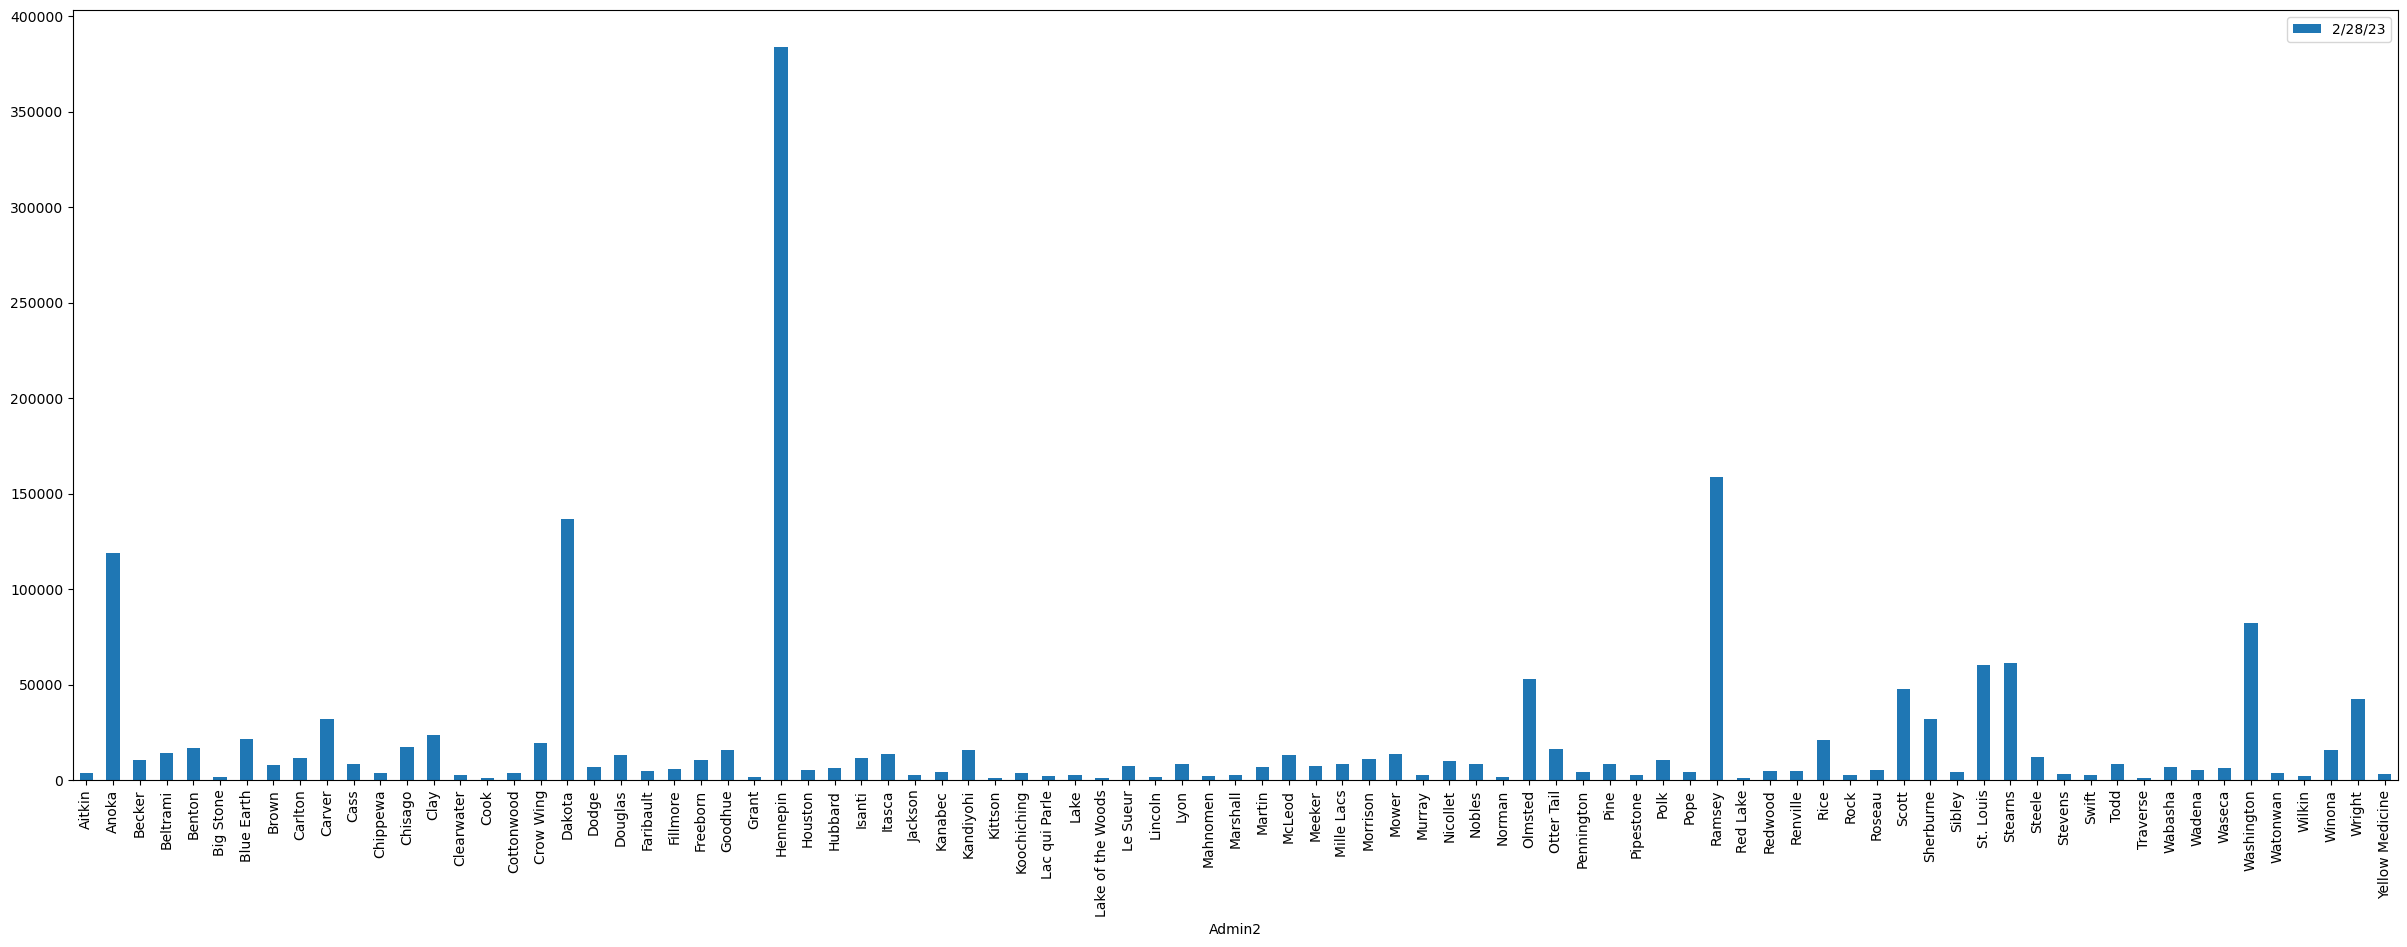

In [6]:
minnesota_df.plot("Admin2","2/28/23",kind="bar",figsize=(30,10))


In [7]:
#Cleaning code

In [ ]:
#Viktor

In [ ]:
#Viktor

In [ ]:
#Samantha

In [ ]:
#Samantha

In [ ]:
#Nicholas

In [41]:
state_gdp_df = pd.read_csv(file2)
clean_state_gdp_df = state_gdp_df.loc[state_gdp_df["LineCode"] == 1]
clean_state_gdp_df2 = clean_state_gdp_df[clean_state_gdp_df["GeoName"] != "United States"].reset_index(drop = True)
clean_state_gdp_df3 = clean_state_gdp_df2.drop(clean_state_gdp_df2.tail(8).index)
clean_state_gdp_rename_df = clean_state_gdp_df3.rename(columns = {"2016" : "2016 RGDP", "2017" : "2017 RGDP", "2018" : "2018 RGDP","2019": "2019 RGDP", "2020" : "2020 RGDP" , "2021" : "2021 RGDP", "2022": "2022 RGDP", "2023" : "2023 RGDP", "GeoName" : "Province_State"})
state_gdp_df_clean = clean_state_gdp_rename_df.drop(columns = {"GeoFips", "LineCode", "Description"})

In [42]:
population_df = pd.read_csv(file4)
clean_pop_df = population_df.loc[population_df["Country_Region"] == "US"].reset_index(drop = True)
clean_pop_df2 = clean_pop_df.loc[clean_pop_df["FIPS"].between(1,56)].reset_index(drop = True)
clean_final_pop_df = clean_pop_df2.drop(columns = {"UID", "iso2", "iso3", "code3", "FIPS", "Admin2", "Country_Region", "Combined_Key"})

In [43]:
Start2020 = covid_df.groupby(["Province_State"])["1/22/20"].min()
End2020 = covid_df.groupby(["Province_State"])["12/31/20"].sum()
End2021 = covid_df.groupby(["Province_State"])["12/31/21"].sum()
End2022 = covid_df.groupby(["Province_State"])["12/31/22"].sum()
End2023 = covid_df.groupby(["Province_State"])["3/9/23"].sum()

average_infections_state = pd.DataFrame({"Infections as of 1/22/2020": Start2020,
                                     "Infections as of 12/31/2020": End2020,
                                     "Infections as of 12/31/2021": End2021,
                                     "Infections as of 12/31/2022": End2022,
                                     "Infections as of 3/9/2023": End2023})

In [44]:
study_data_partial = pd.merge(average_infections_state, clean_final_pop_df, on=["Province_State"])
study_data_full = pd.merge(study_data_partial, state_gdp_df_clean, on=["Province_State"])

In [45]:
gdf = gpd.read_file('./Data/cb_2018_us_state_500k')
clean1_gdf = gdf.rename(columns = {"NAME" : "Province_State"})
clean_gdf = clean1_gdf.drop(columns = {"STATEFP", "STATENS", "AFFGEOID", "GEOID", "STUSPS", "LSAD", "ALAND", "AWATER"})

In [46]:
final_df = clean_gdf.merge(study_data_full, on=["Province_State"])
final_df["2020 Infections per 100k"] = ((final_df["Infections as of 12/31/2020"]/final_df["Population"])*100000)
final_df["2021 Infections per 100k"] = (((final_df["Infections as of 12/31/2021"] - final_df["Infections as of 12/31/2020"])/final_df["Population"])*100000)
final_df["2022 Infections per 100k"] = (((final_df["Infections as of 12/31/2022"] - final_df["Infections as of 12/31/2021"])/final_df["Population"])*100000)
final_df["03.09.2023 Infections per 100k"] = (((final_df["Infections as of 3/9/2023"] - final_df["Infections as of 12/31/2022"])/final_df["Population"])*100000)

c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\nfsab\AppData\Local\Temp\ipykernel_5632\1528356851.py:70: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  hawaii.clip(hawaiipolygon).plot(column=variable, color=hawaii['value_determined_color'], linewidth=0.8,ax=hawaiiaxis, edgecolor='0.8')


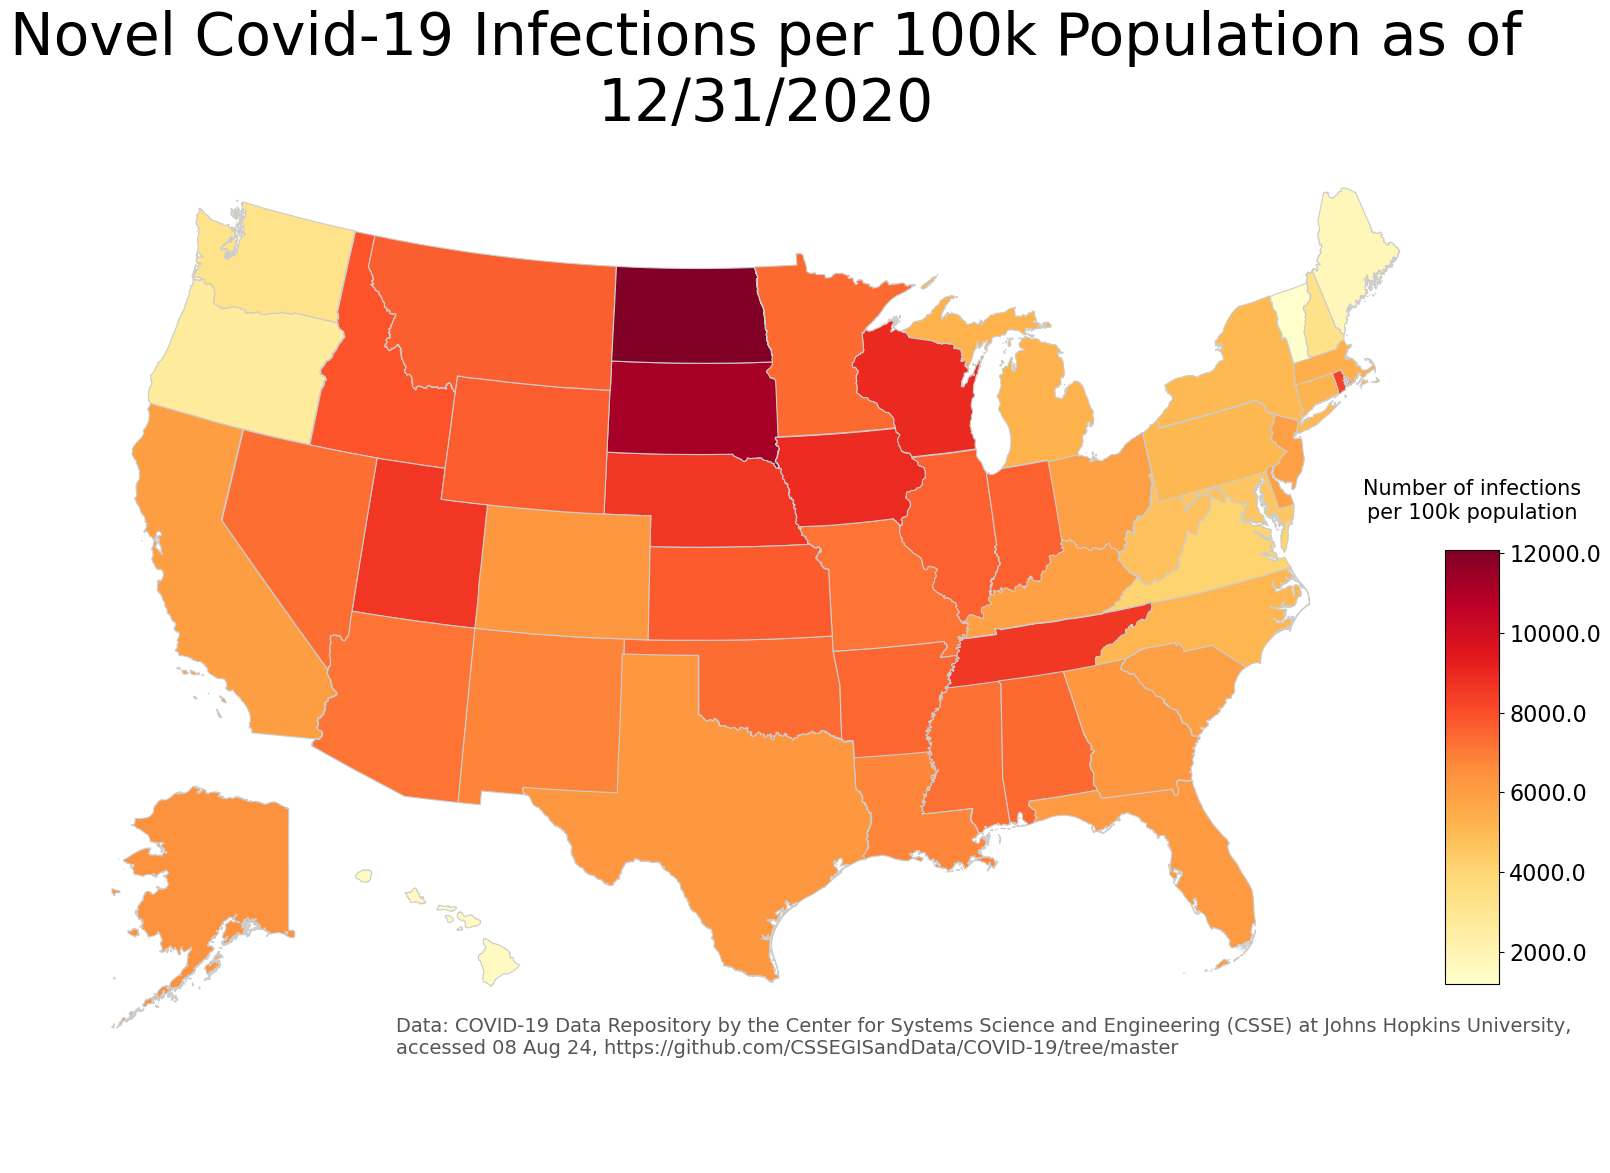

In [47]:
#The variable column that will be visualized
variable = '2020 Infections per 100k'

def makeColorColumn(final_df,variable,vmin,vmax):
    #Creates a column of assigned colors
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.YlOrRd)
    final_df['value_determined_color'] = final_df[variable].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
    return final_df

#Setting the range and bounds for the colorbar
vmin, vmax = final_df["2020 Infections per 100k"].min(), final_df["2020 Infections per 100k"].max()
colormap = "YlOrRd"
final_df = makeColorColumn(final_df,variable,vmin,vmax)

#Creating a dataframe that would hold the ESPG code which will format the visual
visframe = final_df.to_crs({'init':'epsg:2163'})



#Matplotlib, creating the figure
fig, ax = plt.subplots(1, figsize=(18, 14))
#Removing the axis box from around the visualization
ax.axis('off')

#Title of the graph
ax.set_title('Novel Covid-19 Infections per 100k Population as of\n12/31/2020', fontdict={'fontsize': '42', 'fontweight' : '1'})

#Creating a legend for the colorbar
fig = ax.get_figure()
#Adding in the colorbar axis
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])   

cbax.set_title('Number of infections\nper 100k population\n', fontdict={'fontsize': '15', 'fontweight' : '0'})

#Adding in a color scale
sm = plt.cm.ScalarMappable(cmap=colormap, \
                 norm=plt.Normalize(vmin=vmin, vmax=vmax))
#Reformatting tick labels
sm._A = []
comma_fmt = FuncFormatter(lambda x, p: format(x))
fig.colorbar(sm, cax=cbax, format=comma_fmt)
tick_font_size = 16
cbax.tick_params(labelsize=tick_font_size)
#Annotating the link to the data
ax.annotate("Data: COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University,\naccessed 08 Aug 24, https://github.com/CSSEGISandData/COVID-19/tree/master", xy=(0.22, .085), xycoords='figure fraction', fontsize=14, color='#555555')

#Creating the map
for row in visframe.itertuples():
    if row.Province_State not in ['Alaska','Hawaii']:
        vf = visframe[visframe.Province_State==row.Province_State]
        c = final_df[final_df.Province_State==row.Province_State][0:1].value_determined_color.item()
        vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor='0.8')

#Adding in Alaska
alaskaaxis = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
alaskaaxis.axis('off')
#Polygon for capturing the Aleutian Islands
alaskapolygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
alaska = final_df[final_df.Province_State=='Alaska']
alaska.clip(alaskapolygon).plot(color=final_df[final_df.Province_State=='Alaska'].value_determined_color, linewidth=0.8,ax=alaskaaxis, edgecolor='0.8')


#Adding in Hawii to the bottom left corner
hawaiiaxis = fig.add_axes([.28, 0.20, 0.1, 0.1])   
hawaiiaxis.axis('off')
#Polygon for capturing the entirety of Hawaii
hawaiipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
hawaii = final_df[final_df.Province_State=='Hawaii']
hawaii.clip(hawaiipolygon).plot(column=variable, color=hawaii['value_determined_color'], linewidth=0.8,ax=hawaiiaxis, edgecolor='0.8')


fig.savefig('./Data/2020Infections.png',dpi=400, bbox_inches="tight")

c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\nfsab\AppData\Local\Temp\ipykernel_5632\1639961429.py:70: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  hawaii.clip(hawaiipolygon).plot(column=variable, color=hawaii['value_determined_color'], linewidth=0.8,ax=hawaiiaxis, edgecolor='0.8')


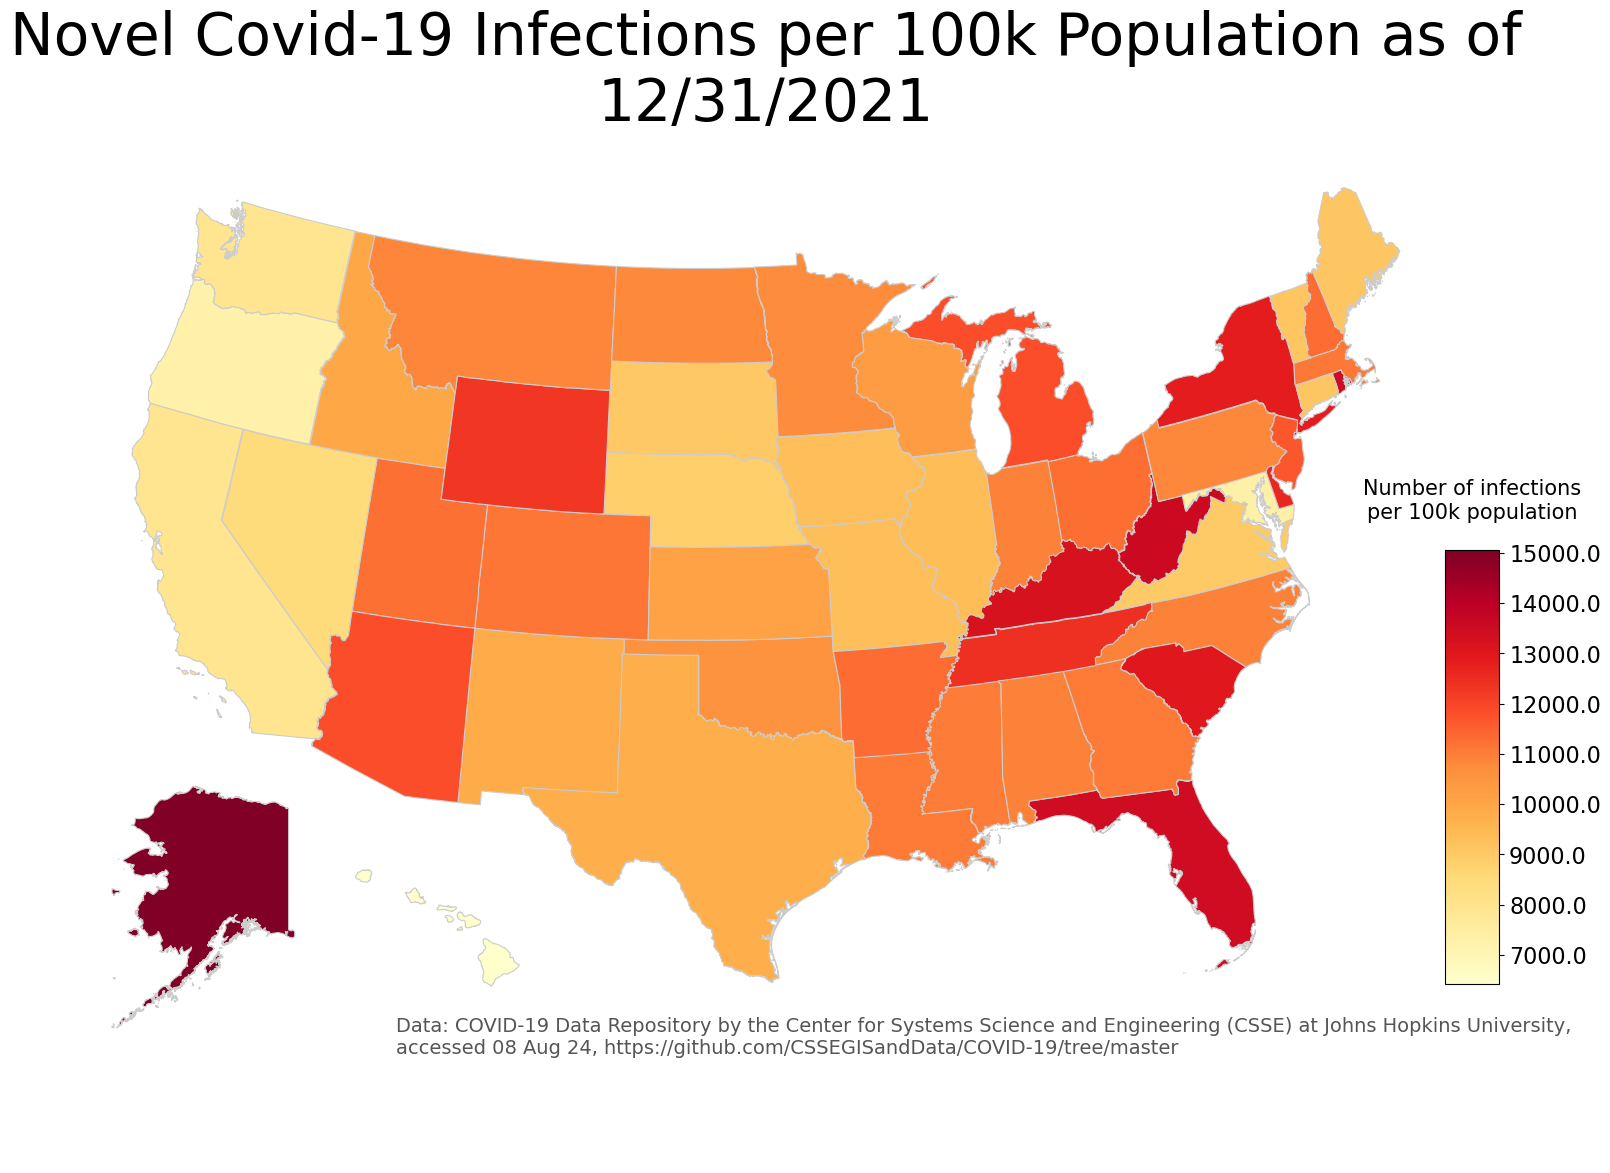

In [48]:
#The variable column that will be visualized
variable = '2021 Infections per 100k'

def makeColorColumn(final_df,variable,vmin,vmax):
    #Creates a column of assigned colors
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.YlOrRd)
    final_df['value_determined_color'] = final_df[variable].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
    return final_df

#Setting the range and bounds for the colorbar
vmin, vmax = final_df["2021 Infections per 100k"].min(), final_df["2021 Infections per 100k"].max()
colormap = "YlOrRd"
final_df = makeColorColumn(final_df,variable,vmin,vmax)

#Creating a dataframe that would hold the ESPG code which will format the visual
visframe = final_df.to_crs({'init':'epsg:2163'})



#Matplotlib, creating the figure
fig, ax = plt.subplots(1, figsize=(18, 14))
#Removing the axis box from around the visualization
ax.axis('off')

#Title of the graph
ax.set_title('Novel Covid-19 Infections per 100k Population as of\n12/31/2021', fontdict={'fontsize': '42', 'fontweight' : '1'})

#Creating a legend for the colorbar
fig = ax.get_figure()
#Adding in the colorbar axis
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])   

cbax.set_title('Number of infections\nper 100k population\n', fontdict={'fontsize': '15', 'fontweight' : '0'})

#Adding in a color scale
sm = plt.cm.ScalarMappable(cmap=colormap, \
                 norm=plt.Normalize(vmin=vmin, vmax=vmax))
#Reformatting tick labels
sm._A = []
comma_fmt = FuncFormatter(lambda x, p: format(x))
fig.colorbar(sm, cax=cbax, format=comma_fmt)
tick_font_size = 16
cbax.tick_params(labelsize=tick_font_size)
#Annotating the link to the data
ax.annotate("Data: COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University,\naccessed 08 Aug 24, https://github.com/CSSEGISandData/COVID-19/tree/master", xy=(0.22, .085), xycoords='figure fraction', fontsize=14, color='#555555')

#Creating the map
for row in visframe.itertuples():
    if row.Province_State not in ['Alaska','Hawaii']:
        vf = visframe[visframe.Province_State==row.Province_State]
        c = final_df[final_df.Province_State==row.Province_State][0:1].value_determined_color.item()
        vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor='0.8')

#Adding in Alaska
alaskaaxis = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
alaskaaxis.axis('off')
#Polygon for capturing the Aleutian Islands
alaskapolygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
alaska = final_df[final_df.Province_State=='Alaska']
alaska.clip(alaskapolygon).plot(color=final_df[final_df.Province_State=='Alaska'].value_determined_color, linewidth=0.8,ax=alaskaaxis, edgecolor='0.8')


#Adding in Hawii to the bottom left corner
hawaiiaxis = fig.add_axes([.28, 0.20, 0.1, 0.1])   
hawaiiaxis.axis('off')
#Polygon for capturing the entirety of Hawaii
hawaiipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
hawaii = final_df[final_df.Province_State=='Hawaii']
hawaii.clip(hawaiipolygon).plot(column=variable, color=hawaii['value_determined_color'], linewidth=0.8,ax=hawaiiaxis, edgecolor='0.8')


fig.savefig('./Data/2021Infections.png',dpi=400, bbox_inches="tight")

c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\nfsab\AppData\Local\Temp\ipykernel_5632\3371119067.py:70: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  hawaii.clip(hawaiipolygon).plot(column=variable, color=hawaii['value_determined_color'], linewidth=0.8,ax=hawaiiaxis, edgecolor='0.8')


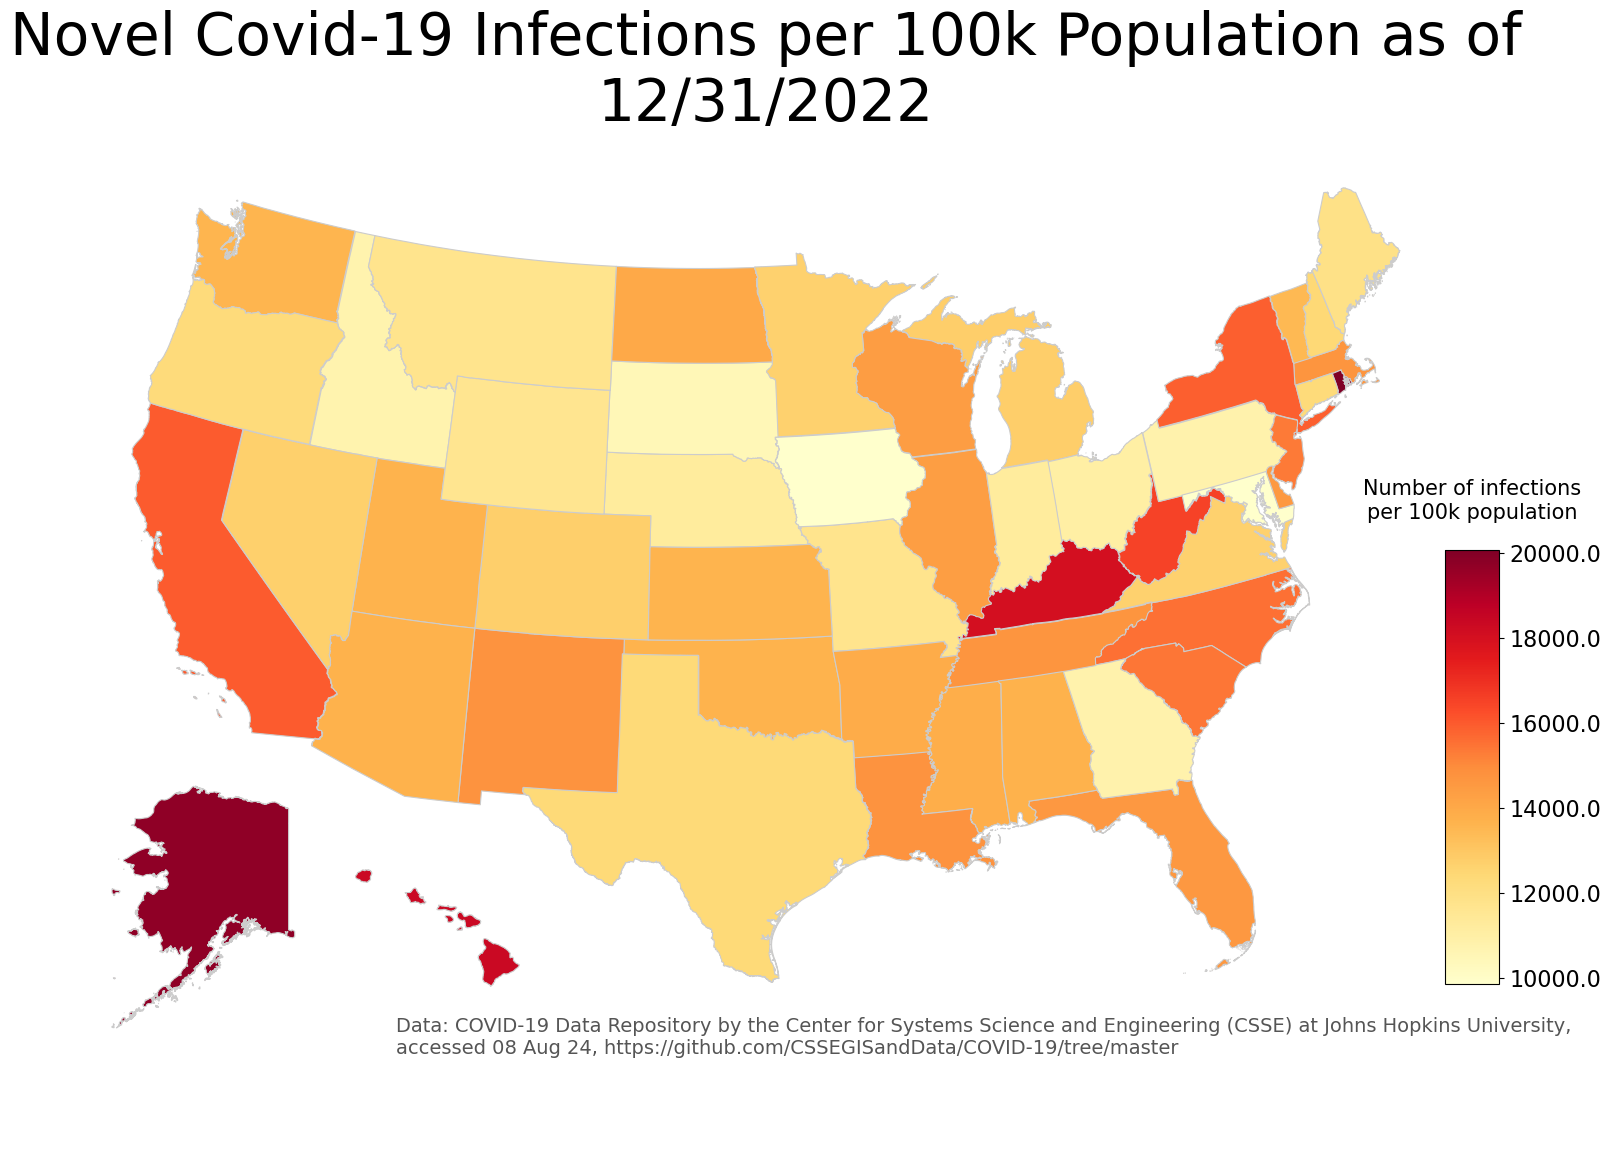

In [49]:
#The variable column that will be visualized
variable = '2022 Infections per 100k'

def makeColorColumn(final_df,variable,vmin,vmax):
    #Creates a column of assigned colors
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.YlOrRd)
    final_df['value_determined_color'] = final_df[variable].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
    return final_df

#Setting the range and bounds for the colorbar
vmin, vmax = final_df["2022 Infections per 100k"].min(), final_df["2022 Infections per 100k"].max()
colormap = "YlOrRd"
final_df = makeColorColumn(final_df,variable,vmin,vmax)

#Creating a dataframe that would hold the ESPG code which will format the visual
visframe = final_df.to_crs({'init':'epsg:2163'})



#Matplotlib, creating the figure
fig, ax = plt.subplots(1, figsize=(18, 14))
#Removing the axis box from around the visualization
ax.axis('off')

#Title of the graph
ax.set_title('Novel Covid-19 Infections per 100k Population as of\n12/31/2022', fontdict={'fontsize': '42', 'fontweight' : '1'})

#Creating a legend for the colorbar
fig = ax.get_figure()
#Adding in the colorbar axis
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])   

cbax.set_title('Number of infections\nper 100k population\n', fontdict={'fontsize': '15', 'fontweight' : '0'})

#Adding in a color scale
sm = plt.cm.ScalarMappable(cmap=colormap, \
                 norm=plt.Normalize(vmin=vmin, vmax=vmax))
#Reformatting tick labels
sm._A = []
comma_fmt = FuncFormatter(lambda x, p: format(x))
fig.colorbar(sm, cax=cbax, format=comma_fmt)
tick_font_size = 16
cbax.tick_params(labelsize=tick_font_size)
#Annotating the link to the data
ax.annotate("Data: COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University,\naccessed 08 Aug 24, https://github.com/CSSEGISandData/COVID-19/tree/master", xy=(0.22, .085), xycoords='figure fraction', fontsize=14, color='#555555')

#Creating the map
for row in visframe.itertuples():
    if row.Province_State not in ['Alaska','Hawaii']:
        vf = visframe[visframe.Province_State==row.Province_State]
        c = final_df[final_df.Province_State==row.Province_State][0:1].value_determined_color.item()
        vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor='0.8')

#Adding in Alaska
alaskaaxis = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
alaskaaxis.axis('off')
#Polygon for capturing the Aleutian Islands
alaskapolygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
alaska = final_df[final_df.Province_State=='Alaska']
alaska.clip(alaskapolygon).plot(color=final_df[final_df.Province_State=='Alaska'].value_determined_color, linewidth=0.8,ax=alaskaaxis, edgecolor='0.8')


#Adding in Hawii to the bottom left corner
hawaiiaxis = fig.add_axes([.28, 0.20, 0.1, 0.1])   
hawaiiaxis.axis('off')
#Polygon for capturing the entirety of Hawaii
hawaiipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
hawaii = final_df[final_df.Province_State=='Hawaii']
hawaii.clip(hawaiipolygon).plot(column=variable, color=hawaii['value_determined_color'], linewidth=0.8,ax=hawaiiaxis, edgecolor='0.8')


fig.savefig('./Data/2022Infections.png',dpi=400, bbox_inches="tight")

c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\nfsab\AppData\Local\Temp\ipykernel_5632\1920429498.py:70: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  hawaii.clip(hawaiipolygon).plot(column=variable, color=hawaii['value_determined_color'], linewidth=0.8,ax=hawaiiaxis, edgecolor='0.8')


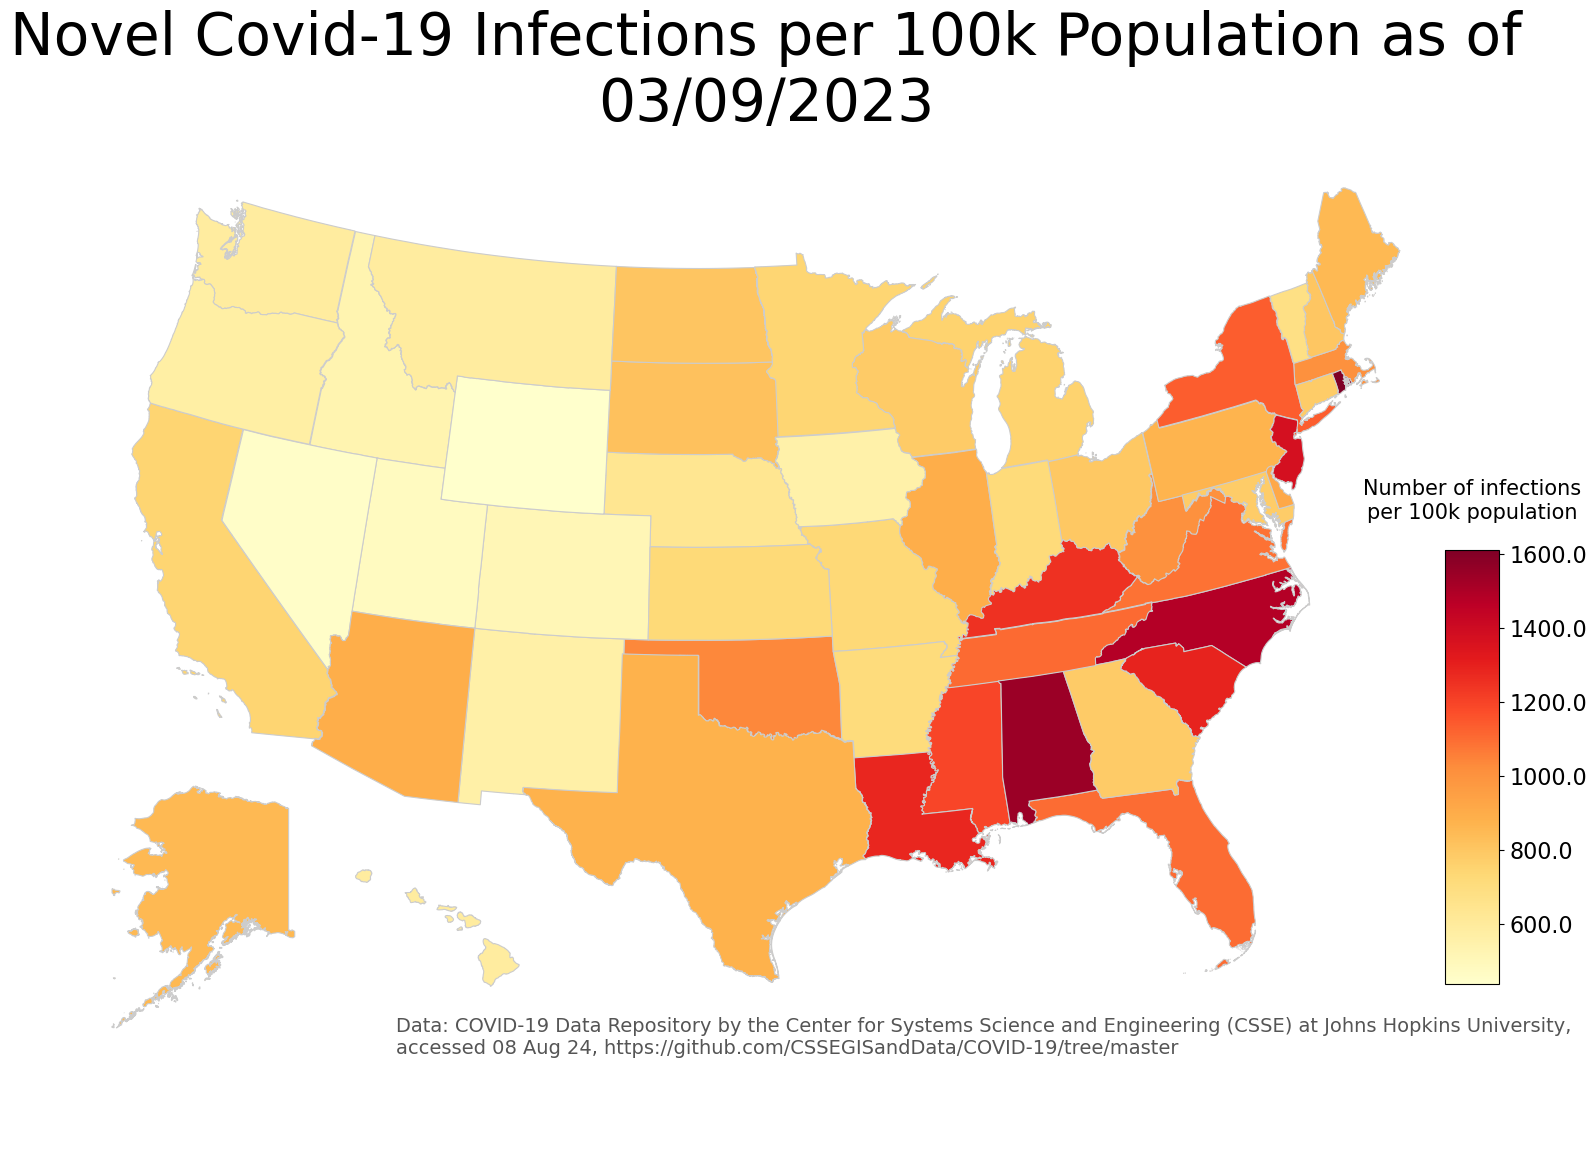

In [50]:
#The variable column that will be visualized
variable = '03.09.2023 Infections per 100k'

def makeColorColumn(final_df,variable,vmin,vmax):
    #Creates a column of assigned colors
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.YlOrRd)
    final_df['value_determined_color'] = final_df[variable].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
    return final_df

#Setting the range and bounds for the colorbar
vmin, vmax = final_df["03.09.2023 Infections per 100k"].min(), final_df["03.09.2023 Infections per 100k"].max()
colormap = "YlOrRd"
final_df = makeColorColumn(final_df,variable,vmin,vmax)

#Creating a dataframe that would hold the ESPG code which will format the visual
visframe = final_df.to_crs({'init':'epsg:2163'})



#Matplotlib, creating the figure
fig, ax = plt.subplots(1, figsize=(18, 14))
#Removing the axis box from around the visualization
ax.axis('off')

#Title of the graph
ax.set_title('Novel Covid-19 Infections per 100k Population as of\n03/09/2023', fontdict={'fontsize': '42', 'fontweight' : '1'})

#Creating a legend for the colorbar
fig = ax.get_figure()
#Adding in the colorbar axis
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])   

cbax.set_title('Number of infections\nper 100k population\n', fontdict={'fontsize': '15', 'fontweight' : '0'})

#Adding in a color scale
sm = plt.cm.ScalarMappable(cmap=colormap, \
                 norm=plt.Normalize(vmin=vmin, vmax=vmax))
#Reformatting tick labels
sm._A = []
comma_fmt = FuncFormatter(lambda x, p: format(x))
fig.colorbar(sm, cax=cbax, format=comma_fmt)
tick_font_size = 16
cbax.tick_params(labelsize=tick_font_size)
#Annotating the link to the data
ax.annotate("Data: COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University,\naccessed 08 Aug 24, https://github.com/CSSEGISandData/COVID-19/tree/master", xy=(0.22, .085), xycoords='figure fraction', fontsize=14, color='#555555')

#Creating the map
for row in visframe.itertuples():
    if row.Province_State not in ['Alaska','Hawaii']:
        vf = visframe[visframe.Province_State==row.Province_State]
        c = final_df[final_df.Province_State==row.Province_State][0:1].value_determined_color.item()
        vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor='0.8')

#Adding in Alaska
alaskaaxis = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
alaskaaxis.axis('off')
#Polygon for capturing the Aleutian Islands
alaskapolygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
alaska = final_df[final_df.Province_State=='Alaska']
alaska.clip(alaskapolygon).plot(color=final_df[final_df.Province_State=='Alaska'].value_determined_color, linewidth=0.8,ax=alaskaaxis, edgecolor='0.8')


#Adding in Hawii to the bottom left corner
hawaiiaxis = fig.add_axes([.28, 0.20, 0.1, 0.1])   
hawaiiaxis.axis('off')
#Polygon for capturing the entirety of Hawaii
hawaiipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
hawaii = final_df[final_df.Province_State=='Hawaii']
hawaii.clip(hawaiipolygon).plot(column=variable, color=hawaii['value_determined_color'], linewidth=0.8,ax=hawaiiaxis, edgecolor='0.8')


fig.savefig('./Data/2023Infections.png',dpi=400, bbox_inches="tight")

c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\nfsab\AppData\Local\Temp\ipykernel_5632\3501407061.py:70: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  hawaii.clip(hawaiipolygon).plot(column=variable, color=hawaii['value_determined_color'], linewidth=0.8,ax=hawaiiaxis, edgecolor='0.8')


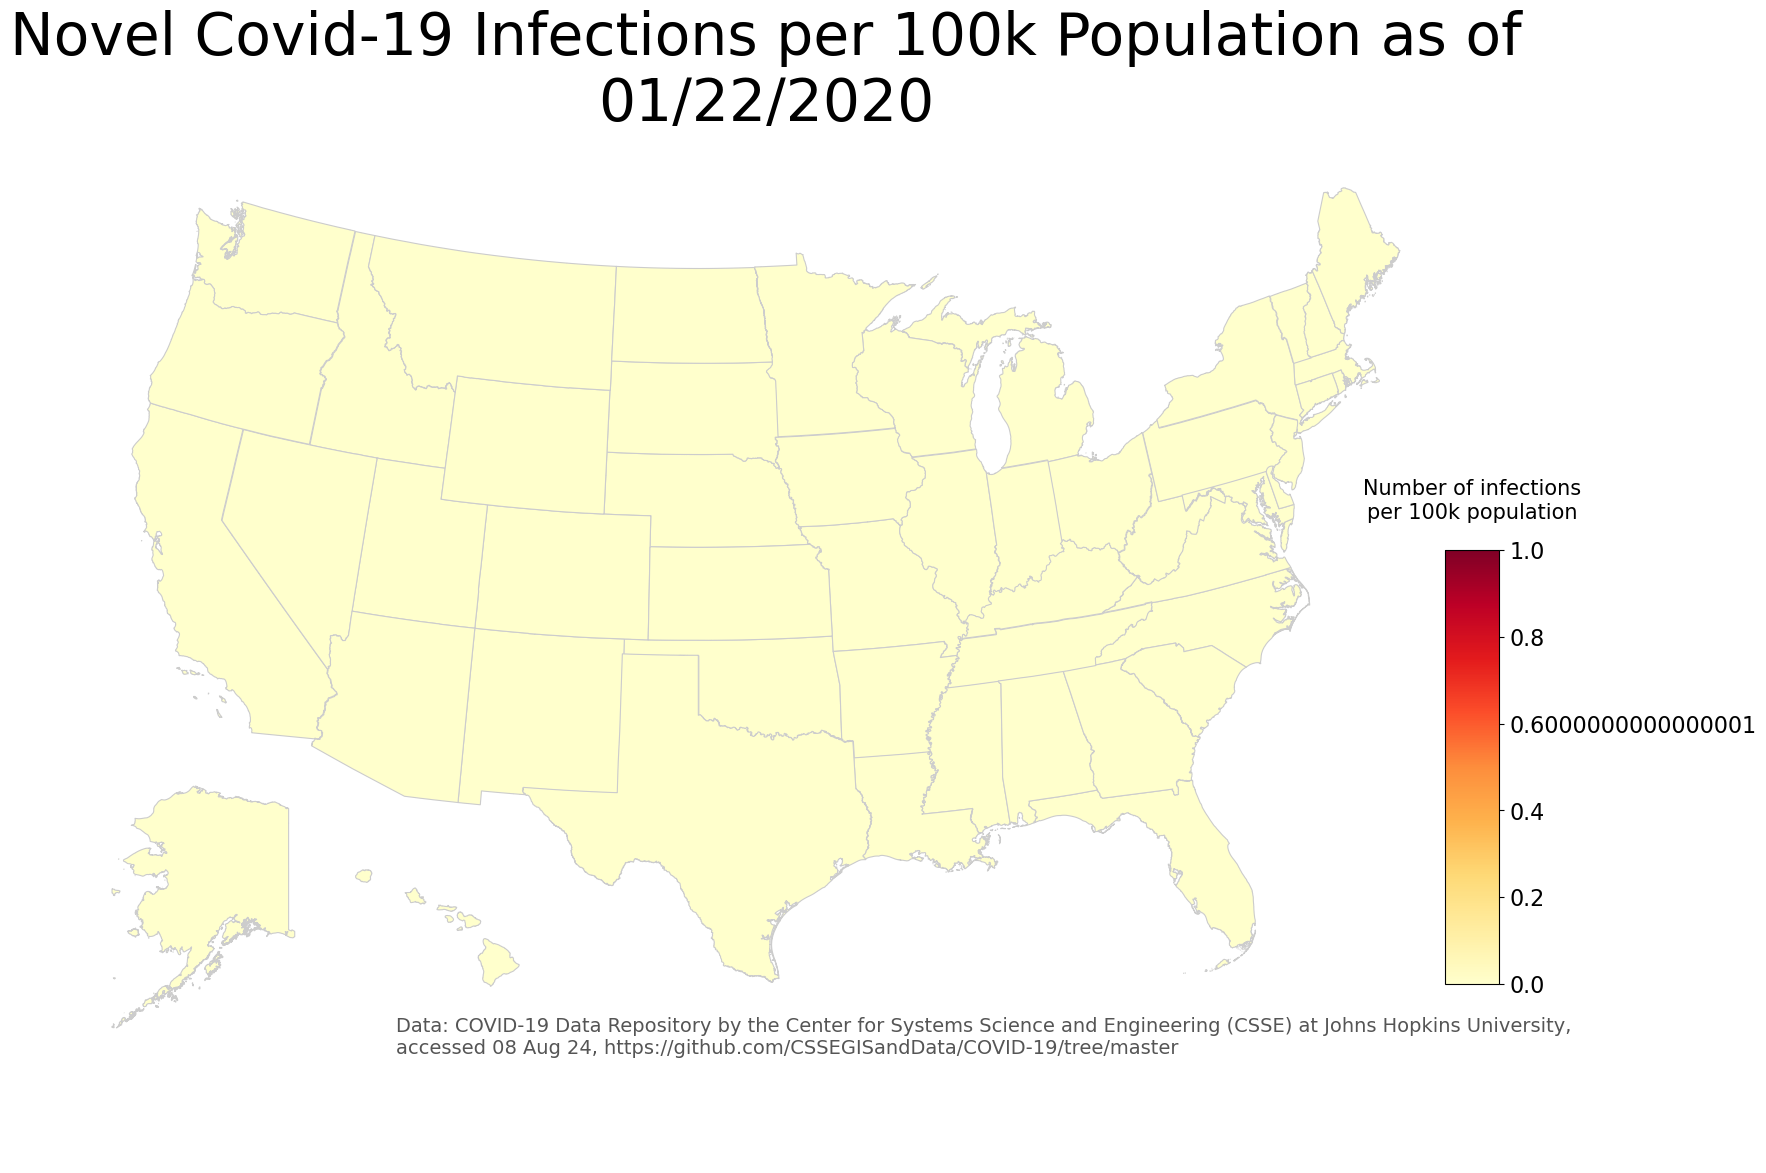

In [51]:
#The variable column that will be visualized
variable = 'Infections as of 1/22/2020'

def makeColorColumn(final_df,variable,vmin,vmax):
    #Creates a column of assigned colors
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.YlOrRd)
    final_df['value_determined_color'] = final_df[variable].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
    return final_df

#Setting the range and bounds for the colorbar
vmin, vmax = final_df["Infections as of 1/22/2020"].min(), final_df["Infections as of 1/22/2020"].max()
colormap = "YlOrRd"
final_df = makeColorColumn(final_df,variable,vmin,vmax)

#Creating a dataframe that would hold the ESPG code which will format the visual
visframe = final_df.to_crs({'init':'epsg:2163'})

#Matplotlib, creating the figure
fig, ax = plt.subplots(1, figsize=(18, 14))
#Removing the axis box from around the visualization
ax.axis('off')

#Title of the graph
ax.set_title('Novel Covid-19 Infections per 100k Population as of\n01/22/2020', fontdict={'fontsize': '42', 'fontweight' : '1'})

#Creating a legend for the colorbar
fig = ax.get_figure()
#Adding in the colorbar axis
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])   

cbax.set_title('Number of infections\nper 100k population\n', fontdict={'fontsize': '15', 'fontweight' : '0'})

#Adding in a color scale
sm = plt.cm.ScalarMappable(cmap=colormap)
#Reformatting tick labels
sm._A = []
comma_fmt = FuncFormatter(lambda x, p: format(x))
fig.colorbar(sm, cax=cbax, format=comma_fmt)
tick_font_size = 16
cbax.tick_params(labelsize=tick_font_size)
#Annotating the link to the data
ax.annotate("Data: COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University,\naccessed 08 Aug 24, https://github.com/CSSEGISandData/COVID-19/tree/master", xy=(0.22, .085), xycoords='figure fraction', fontsize=14, color='#555555')


#Creating the map
for row in visframe.itertuples():
    if row.Province_State not in ['Alaska','Hawaii']:
        vf = visframe[visframe.Province_State==row.Province_State]
        c = final_df[final_df.Province_State==row.Province_State][0:1].value_determined_color.item()
        vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor='0.8')



#Adding in Alaska
alaskaaxis = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
alaskaaxis.axis('off')
#Polygon for capturing the Aleutian Islands
alaskapolygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
alaska = final_df[final_df.Province_State=='Alaska']
alaska.clip(alaskapolygon).plot(color=final_df[final_df.Province_State=='Alaska'].value_determined_color, linewidth=0.8,ax=alaskaaxis, edgecolor='0.8')


#Adding in Hawii to the bottom left corner
hawaiiaxis = fig.add_axes([.28, 0.20, 0.1, 0.1])   
hawaiiaxis.axis('off')
#Polygon for capturing the entirety of Hawaii
hawaiipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
hawaii = final_df[final_df.Province_State=='Hawaii']
hawaii.clip(hawaiipolygon).plot(column=variable, color=hawaii['value_determined_color'], linewidth=0.8,ax=hawaiiaxis, edgecolor='0.8')


fig.savefig('./Data/2020StartInfections.png',dpi=400, bbox_inches="tight")

In [52]:
#Nicholas

In [53]:
#Mysee

In [54]:
#Mysee

In [55]:
#Micah

In [56]:
#Micah